In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from tensorflow.keras import layers, models
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline
import ta
import seaborn as sns

In [9]:


def add_technical_indicator(file_path):
    df_stock = pd.read_csv(file_path)

    # Convert 'Date' column to datetime
    df_stock['Date'] = pd.to_datetime(df_stock['Date'], format='%Y-%m-%d')

    # Clean 'Percent Change' column
    if 'Percent Change' in df_stock.columns:
        df_stock['Percent Change'] = df_stock['Percent Change'].str.replace('%', '', regex=True).apply(pd.to_numeric, errors='coerce')

    # Clean 'Volume' column (assuming 'Qty' represents volume)
    if 'Volume' in df_stock.columns:
        df_stock['Volume'] = df_stock['Volume'].astype(str).str.replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')

    # Extract time-based features
    df_stock['day_of_week'] = df_stock['Date'].dt.dayofweek
    df_stock['month'] = df_stock['Date'].dt.month

    # Use 'Ltp' instead of 'Close' if necessary
    close_col = 'Close'
    high_col = 'High'
    low_col = 'Low'
    volume_col = 'Volume'

    # Technical indicators
    df_stock['Returns'] = df_stock[close_col].pct_change().fillna(0)
    df_stock['MACD'] = ta.trend.MACD(df_stock[close_col]).macd().fillna(0)
    df_stock['Signal'] = ta.trend.MACD(df_stock[close_col]).macd_signal().fillna(0)
    df_stock['RSI'] = ta.momentum.RSIIndicator(df_stock[close_col]).rsi().fillna(50)
    df_stock['SMA_20'] = df_stock[close_col].rolling(window=20, min_periods=1).mean()
    df_stock['SMA_50'] = df_stock[close_col].rolling(window=50, min_periods=1).mean()
    df_stock['EMA_20'] = ta.trend.EMAIndicator(df_stock[close_col], window=20).ema_indicator().fillna(0)

    # Volatility measures
    df_stock['Volatility'] = df_stock['Returns'].rolling(window=20).std().fillna(0)
    df_stock['ATR'] = ta.volatility.AverageTrueRange(df_stock[high_col], df_stock[low_col], df_stock[close_col]).average_true_range().fillna(0)

    # Volume-based indicators
    df_stock['Volume_SMA'] = df_stock[volume_col].rolling(window=20).mean().fillna(0)
    df_stock['Volume_Ratio'] = (df_stock[volume_col] / df_stock['Volume_SMA']).fillna(1)

    # Momentum indicators
    df_stock['MFI'] = ta.volume.MFIIndicator(df_stock[high_col], df_stock[low_col], df_stock[close_col], df_stock[volume_col]).money_flow_index().fillna(50)

    return df_stock

# Function for feature selection using Pearson correlation
def select_features(X, threshold=0.8):
    # Remove non-numeric columns (if any) for correlation computation
    X_numeric = X.select_dtypes(include=[np.number])
    
    col_corr = set()
    corr_matrix = X_numeric.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.CMRmap_r)
    plt.show()

    # Check for highly correlated features and add them to the set to be dropped
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    
    return X.drop(columns=col_corr)

def preprocess_data(file_path):
    # Add technical indicators
    df = add_technical_indicator(file_path)

    # Select features and target
    target = 'Close'  
    
    # Extract relevant features (exclude non-numeric columns)
    features = ['Close', 'day_of_week', 'month', 'Returns', 'MACD', 'Signal', 'RSI', 'SMA_20', 'SMA_50', 'EMA_20', 'Volatility', 'ATR', 'Volume_SMA', 'MFI']
    
    # Remove highly correlated features
    df_selected = select_features(df[features])

    # Drop 'Volume_Ratio' if present (or any other feature that should not be used)
    if "Volume_Ratio" in df_selected.columns:
        df_selected = df_selected.drop("Volume_Ratio", axis=1)

    # Select the final set of features after removing unwanted columns
    features = [col for col in df_selected.columns if col != [target,'Symbol','Date']]
    print("Feature statistics:\n", df_selected.describe())

    # Scale features (excluding target)
    scaler = MinMaxScaler()
    df_selected[features] = scaler.fit_transform(df_selected[features])

    # Save the scaler for future use
    scaler_save_path = file_path.replace('.csv', '_scaler.pkl')
    features_save_path=file_path.replace('.csv', '_features.pkl')
    joblib.dump(scaler, scaler_save_path)
    joblib.dump(features, features_save_path)

    # Return processed dataframe, features, target, and the scaler
    return df_selected, features, target, scaler


Processing NUBL...


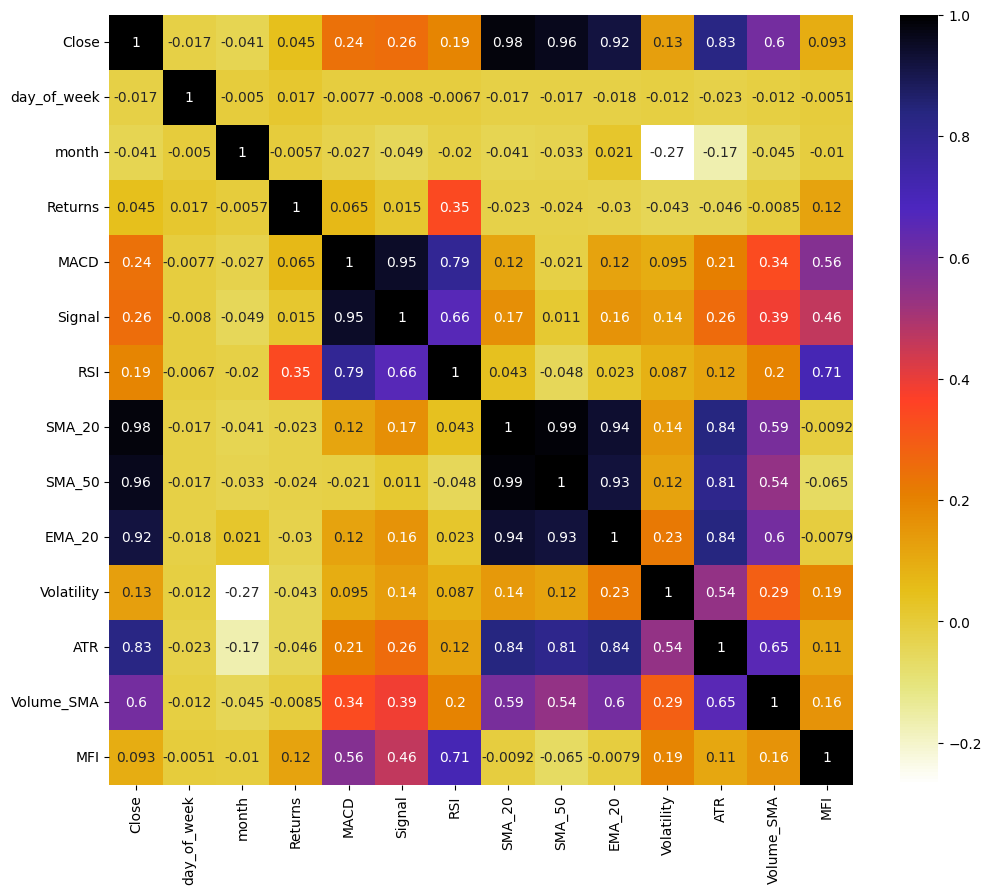

Feature statistics:
              Close  day_of_week        month      Returns         MACD  \
count  1120.000000  1120.000000  1120.000000  1120.000000  1120.000000   
mean   1002.493214     2.388393     6.526786    -0.000013    -2.246773   
std     358.035001     2.023554     3.482267     0.024109    27.824230   
min     530.000000     0.000000     1.000000    -0.230868   -90.289593   
25%     678.275000     1.000000     3.000000    -0.012159   -18.329578   
50%     965.550000     2.000000     7.000000    -0.001465    -3.267082   
75%    1203.250000     3.000000     9.000000     0.010039     9.209460   
max    1870.000000     6.000000    12.000000     0.100000    93.886890   

               RSI   Volatility    Volume_SMA          MFI  
count  1120.000000  1120.000000   1120.000000  1120.000000  
mean     48.182006     0.021548  17067.939152    51.776330  
std      12.512017     0.010346  15903.604277    19.130713  
min      15.424398     0.000000      0.000000     7.119122  
25%    

/opt/anaconda3/envs/tft/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 162 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.1874 - mean_absolute_error: 0.1874 - mean_squared_error: 0.0730 - val_loss: 0.2031 - val_mean_absolute_error: 0.2031 - val_mean_squared_error: 0.0425
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0812 - mean_absolute_error: 0.0812 - mean_squared_error: 0.0134 - val_loss: 0.0908 - val_mean_absolute_error: 0.0908 - val_mean_squared_error: 0.0088
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0516 - mean_absolute_error: 0.0516 - mean_squared_error: 0.0050 - val_loss: 0.1306 - val_mean_absolute_error: 0.1306 - val_mean_squared_error: 0.0175
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0571 - mean_absolute_error: 0.0571 - mean_squared_error: 0.0061 - val_loss: 0.0977 - val_mean_absolute_error: 0.0977 - val_mean_squared_error: 0.0099
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0500 - mean_absolute_error: 0.0500 - mean_squared_error: 0.0051 - val_loss: 0.0421 - val_mean_absolute_er

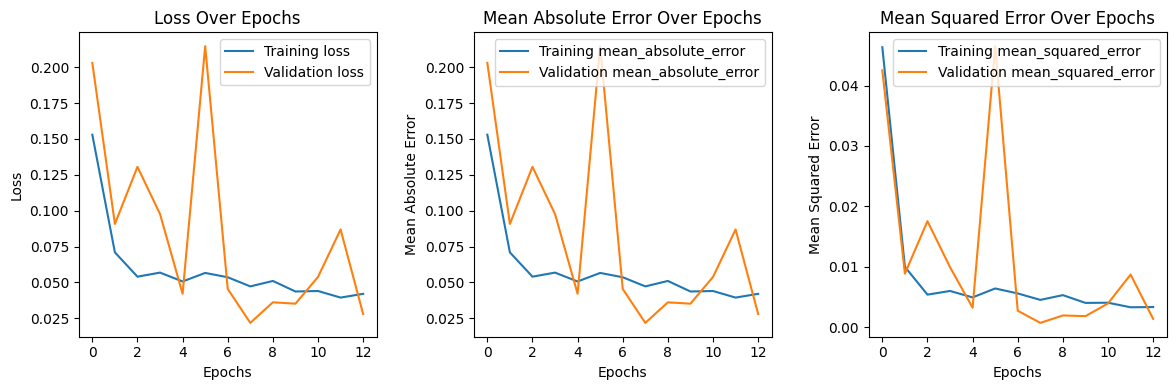

Model for NUBL saved at ../NULB/NUBL_tft_model.keras


In [10]:


# Ensure TensorFlow uses GPU if available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)



def df_to_X_y(df, features, target, window_size=5):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[features].iloc[i:i+window_size].values)
        y.append(df[target].iloc[i+window_size])
    return np.array(X), np.array(y)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
        x = layers.LayerNormalization(epsilon=1e-6)(inputs)
        x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x = layers.Dropout(dropout)(x)
        res = x + inputs

        x = layers.LayerNormalization(epsilon=1e-6)(res)
        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        return x + res

def gated_residual_network(inputs, units): 
        x = layers.Dense(units, activation='relu')(inputs) 
        x = layers.Dense(inputs.shape[-1])(x) 
        gate = layers.Dense(inputs.shape[-1], activation='sigmoid')(inputs) 
        return x * gate + inputs

WINDOW_SIZE = 5

# Function to calculate the percentage error for each prediction
def calculate_accuracy(y_true, y_pred, threshold=0.05):
    # Avoid division by zero
    y_true = np.where(y_true == 0, 1e-8, y_true)
    
    # Compute absolute percentage error
    percentage_error = np.abs((y_true - y_pred) / y_true)

    # Count how many predictions fall within the threshold
    accurate_predictions = np.sum(percentage_error <= threshold)

    # Normalize the accuracy within 0-100%
    accuracy = accurate_predictions / ((len(y_true)) * 100)
    
    return accuracy
def build_model(hp, input_shape):
        input_shape = (WINDOW_SIZE, 9)
        inputs = layers.Input(shape=input_shape)
        x = inputs
        x = gated_residual_network(x, units=hp.Int('grn_units', min_value=32, max_value=128, step=32))
        x = layers.LSTM(units=50, return_sequences=True)(x)
        x = layers.LSTM(units=50, return_sequences=True)(x)
        for i in range(hp.Int('num_transformer_blocks', 2, 8, 2)):
            x = transformer_encoder(
                x,
                head_size=hp.Int('head_size', 8, 256, 32),
                num_heads=hp.Int('num_heads', 2, 16),
                ff_dim=hp.Int('ff_dim', 4, 64),
                dropout=hp.Float(f'dropout_{i}', 0.1, 0.6)
            )
        x = layers.GlobalAveragePooling1D()(x)
        for i in range(hp.Int('num_mlp_layers', 1, 3)):
            x = layers.Dense(hp.Int(f'mlp_units_{i}', 32, 256, 32))(x)
            x = layers.Activation('relu')(x)
            x = layers.Dropout(hp.Float(f'mlp_dropout_{i}', 0.1, 0.6))(x)
        outputs = layers.Dense(1)(x)
        model = models.Model(inputs, outputs)
        optimizer_name = hp.Choice('optimizer', ['adam', 'adamax'])
        learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG',)
        if optimizer_name == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate,clipvalue=1.0)
        else:
            optimizer = keras.optimizers.Adamax(learning_rate=learning_rate,clipvalue=1.0)
        model.compile(
            optimizer=optimizer, 
            loss='mean_absolute_error', 
            metrics=['mean_absolute_error', 'mean_squared_error']
        )
        return model


# After predicting with your trained model
def evaluate_model(model, X_test, y_test):
    # Predict using the trained model
    y_pred = model.predict(X_test)

    # Calculate various metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Calculate accuracy (percentage within 5% threshold)
    accuracy = calculate_accuracy(y_test, y_pred, threshold=0.05)

    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R² Score: {r2}")
    print(f"Accuracy (within 1%): {accuracy * 100:.2f}%")
    
    return mae, mse, r2, accuracy



def train_model(X_train, y_train, input_shape):
    tuner = RandomSearch(lambda hp: build_model(hp, input_shape),
                         objective='mean_absolute_error',
                         max_trials=50,
                         executions_per_trial=50,
                         directory='hyperparam_tuning',
                         project_name='tft_stock')

    tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])
    
    best_model = tuner.get_best_models(num_models=1)[0]
    # Train the best model again on full training data and store history
    history = best_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])
    return best_model,history



def plot_training_history(history):
    metrics = ['loss', 'mean_absolute_error', 'mean_squared_error']
    
    plt.figure(figsize=(12, 4))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.legend()
        plt.title(f'{metric.replace("_", " ").title()} Over Epochs')

    plt.tight_layout()
    plt.show()

# Example of using it after training a model
def train_and_evaluate(data_directory):
    for file_name in os.listdir(data_directory):
        if file_name.endswith('.csv'):
            stock_name = os.path.splitext(file_name)[0]
            file_path = os.path.join(data_directory, file_name)
            print(f"Processing {stock_name}...")

            # Preprocess data
            df, features, target, scaler = preprocess_data(file_path)
            
            print("Columns before df_to_X_y:", df.columns.tolist())
            print("First few rows:\n", df.head())
            print (target)
            # Prepare sequences
            X, y = df_to_X_y(df, features, target)

            if len(X) == 0:
                print(f"Not enough data to train for {stock_name}. Skipping...")
                continue

            # Split data into training and test sets (80% training, 20% testing)
            train_size = int(len(X) * 0.8)
            X_train, X_test = X[:train_size], X[train_size:]
            y_train, y_test = y[:train_size], y[train_size:]

            




            # Train the model
            input_shape = (X.shape[1], X.shape[2])
            model, history = train_model(X_train, y_train, input_shape)

            # Evaluate the model on the test set
            evaluate_model(model, X_test, y_test)

            plot_training_history(history)

            # Save the model for later use
            model_save_path = os.path.join(data_directory, f"{stock_name}_tft_model.keras")
            model.save(model_save_path)
            print(f"Model for {stock_name} saved at {model_save_path}")

if __name__ == "__main__":
    data_directory = '../NULB/'  # Replace with the actual path
    train_and_evaluate(data_directory)
